# Scaling up

Originally released as part of a homework in ADA2019.

## Description

[Reddit](https://www.reddit.com/) aka *'the front page of the internet'* is a network of over a million *communities* aka *'subreddits'*, each of which covers a different topic based on people's interests. In other words, it is a *massive* collection of forums (corresponding to the aforementioned communities), where people can share content specific to a given topic or comment on other people’s posts.   

You are reddit's community manager and want to *appoint new moderators*. Because moderating a specific subreddit isn't a full-time job, you want the chosen moderators to moderate multiple subreddits at the same time. To make this choice effective, the moderators shouldn't have to spend too much time getting to know the community and the prevalent communication style, so it makes sense to let moderators moderate subreddits that are similar in communication style and language. At the same time, it also makes sense to let them moderate subreddits that are similar with respect to the participating users, because this allows moderators to track the behavior of individual users over multiple subreddits. For example, some users might only post offensive content once a month on a given subreddit, and therefore fly under the radar with someone moderating only that subreddit. However, considering all the subreddits these users post to, they might post something offensive every day but on different subreddits. Thus, a moderator in charge of all these subreddits would be able to ban such users much more effectively. In the light of the above description, your task is to find out ways to choose moderators considering both the textual content and the users of a subreddit.

### Dataset:
The dataset provided to you includes all the posts of the 15 largest subreddits written as of May 2015.

Reddit posts (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/19SVHKbUTUPtC9HMmADJcAAIY1Xjq6WFv/view?usp=sharing))
```
reddit_posts
 |-- id: id of the post 
 |-- author: user name of the author 
 |-- body: text of the message
 |-- subreddit: name of the subreddit
```

Reddit scores (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/1vr4PolJzTXr6ODSe3ucib5EAyp3rjxec/view?usp=sharing))
```
reddit_scores
 |-- id: id of the post 
 |-- score: score computed as sum of UP/DOWN votes
```

*Note: Jaccard similarity between subreddits represented using either the set of top-1000 words or the set of users can be computed locally (on the driver), however, all the other tasks have to be implemented in Spark.*

## B1. Getting a sense of the data

Start a PySpark instance...

In [37]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
import numpy as np 
import pandas as pd

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config("spark.sql.broadcastTimeout", "1200").getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

spark

In [38]:
import os
os.environ['PYSPARK_PYTHON']='D:\\Users\\uji_crush\\anaconda3\\envs\\ada\\python.exe'

... and load the data in a Spark dataframe.

In [39]:
reddit = spark.read.json("messages.json.gz")
score = spark.read.json("score.json.gz")

In [40]:
%run hw2_utils.py

In [41]:
reddit.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit: string (nullable = true)



In [42]:
score.printSchema

<bound method DataFrame.printSchema of DataFrame[id: string, score: bigint]>

### B1.1. Identify the most active subreddit

Print the list of subreddits along with the following information:
1. The total number of posts
2. The number of users with at least 1 message
3. The mean message length

*Note: Keep everything in one single dataframe and print the list sorted by number of posts in descending order.*

In [43]:
subreddit_info = reddit.groupBy("subreddit").agg(count("*").alias("total_posts"), 
                                                 countDistinct("author").alias("users_count"), 
                                                 avg(length("body")).alias("posts_length"), 
                                                 stddev(length("body")).alias("posts_length_stddev")
                                                ).cache()
subreddit_info

DataFrame[subreddit: string, total_posts: bigint, users_count: bigint, posts_length: double, posts_length_stddev: double]

In [44]:
by_total_posts = subreddit_info.sort(col("total_posts").desc()).toPandas()

In [45]:
by_total_posts

,subreddit,total_posts,users_count,posts_length,posts_length_stddev
0,leagueoflegends,1151287,119321,152.722808,256.314799
1,nba,704862,45034,106.486568,166.523158
2,funny,691139,224077,106.822839,184.536908
3,pics,564502,205305,114.971005,198.637008
4,nfl,534345,41593,148.969892,237.641786
5,videos,511492,157628,170.227026,290.461162
6,news,477658,98736,230.949160,334.516180
7,DestinyTheGame,471160,37008,165.417869,225.444718
8,soccer,455215,41648,134.422247,203.639870
9,DotA2,445154,41466,141.489067,258.451712


### B1.2. Identify the largest subreddit

Print *two* different lists of subreddits: ordered by (1) the number of posts, and (2) the number of users. For each subreddit, print the name and the corresponding counts.

Additionally, (3) plot the mean of message length for each subreddit in descending order.

In [46]:
by_posts = subreddit_info.select("subreddit","total_posts").sort(col("total_posts").desc()).toPandas()
by_users = subreddit_info.select("subreddit","users_count").sort(col("users_count").desc()).toPandas()

display_side_by_side(by_posts, by_users)

,subreddit,total_posts
0,leagueoflegends,1151287
1,nba,704862
2,funny,691139
3,pics,564502
4,nfl,534345
5,videos,511492
6,news,477658
7,DestinyTheGame,471160
8,soccer,455215
9,DotA2,445154


In [47]:
import math
import matplotlib.pyplot as plt

# .reset_index(drop=True): 重置索引，并删除原来的索引，确保索引从0开始
subreddit_by_pl = subreddit_info.toPandas().sort_values("posts_length",ascending=False).reset_index(drop=True)
sqrt_N = subreddit_by_pl['total_posts'].apply(lambda r: math.sqrt(r))
subreddit_by_pl['ci99'] = 2.576 * (subreddit_by_pl['posts_length_stddev'] / sqrt_N)

subreddit_by_pl

,subreddit,total_posts,users_count,posts_length,posts_length_stddev,ci99
0,news,477658,98736,230.949160,334.516180,1.246822
1,worldnews,439417,99261,224.937547,355.402419,1.381109
2,videos,511492,157628,170.227026,290.461162,1.046199
3,DestinyTheGame,471160,37008,165.417869,225.444718,0.846061
4,movies,354601,92484,164.832093,255.503286,1.105280
5,AdviceAnimals,411902,115815,159.251380,238.983449,0.959217
6,leagueoflegends,1151287,119321,152.722808,256.314799,0.615358
7,nfl,534345,41593,148.969892,237.641786,0.837448
8,GlobalOffensive,382017,46686,147.288398,229.592384,0.956890
9,DotA2,445154,41466,141.489067,258.451712,0.997861


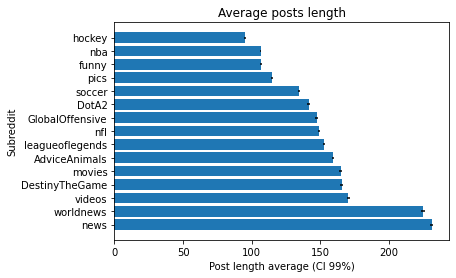

In [48]:
plt.barh(y=subreddit_by_pl['subreddit'],width=subreddit_by_pl['posts_length'], xerr=subreddit_by_pl['ci99'])
plt.xlabel('Post length average (CI 99%)')
plt.ylabel('Subreddit')
plt.title('Average posts length')
plt.show()

### B1.3. Identify the subreddit with the highest average score

Print the list of subreddits sorted by their average content scores.

In [49]:
reddit.join(score,"id").groupBy("subreddit").agg(avg("score").alias("score")).sort(col("score").desc()).show()

+---------------+------------------+
|      subreddit|             score|
+---------------+------------------+
|         videos|12.649445152612358|
|           pics|12.216559020162904|
|          funny|12.041505399058655|
|  AdviceAnimals|11.251695791717447|
|         soccer|10.634627593554693|
|         movies|  9.82014997137628|
|            nfl| 9.048348913155358|
|            nba| 9.032795071943161|
|           news| 8.673421150697779|
|      worldnews|  7.86683719564787|
|         hockey| 6.520120515039979|
|leagueoflegends| 5.983557531701479|
|          DotA2| 4.880537971129092|
|GlobalOffensive| 4.351442475073099|
| DestinyTheGame|3.0288819084811953|
+---------------+------------------+



## B2. Moderator assignment based on Subreddit Textual Content

Different subreddits follow different communication styles inherent in the topic and the community. Having said that, the goal is to discover similar subreddits by only looking at the *words* present in the posted messages. Once such a list of similar subreddits is identified, an appropriately chosen moderator can then be assigned to all these subreddits.

Specifically, the task boils down to computing a similarity score between two subreddits based on the *words* present in their textual content. Your first idea is to use the *Jaccard similarity*, which is defined as the size of the intersection of two sets divided by the size of their union.

$Jaccard(A,B) = \frac{|A \cap B|}{|A \cup B|}$

In [50]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

### B2.1.
The first step requires constructing a set representation of each subreddit. The goal is to represent each subreddit as a *set of words* existing in the messages posted on that subreddit. Compute the 50,000 most frequent words across all the provided subreddits. Construct a representation for each subreddit by retaining only the words found in the previously identified set of 50,000 frequent words.

Some rules:
 * Words are defined as tokens matching the regular expression `\W`
 * Remove all the stop-words (English language)

*Note: You might find the [RegexTokenizer](https://spark.apache.org/docs/2.2.0/ml-features.html#tokenizer) and the [StopWordsRemover](https://spark.apache.org/docs/2.2.0/ml-features.html#stopwordsremover) utilities available in the package pyspark.ml useful for this task as they help you in transforming the features and removing stopwords.*

In [51]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# tokenize the text
# RegexTokenizer是 Spark ML 提供的文本分词工具，它通过正则表达式将输入文本拆分为单词列表
# inputCol="body"：指定输入列为 body
# outputCol="all_words"：将分词结果存入新的列 all_words 中
# pattern="\\W"：正则表达式模式，\\W 表示 "非单词字符"（例如空格、标点符号等），用作分词的边界
regexTokenizer = RegexTokenizer(inputCol="body", outputCol="all_words", pattern="\\W")
reddit_with_words = regexTokenizer.transform(reddit)

# remove stop words
# StopWordsRemover 是 Spark ML 提供的停用词过滤工具，旨在从单词列表中移除常见但信息量较低的词汇
remover = StopWordsRemover(inputCol="all_words", outputCol="words")
reddit_with_tokens = remover.transform(reddit_with_words).drop("all_words")

reddit_with_tokens.show(5)

+-----------------+--------------------+-------+---------------+--------------------+
|           author|                body|     id|      subreddit|               words|
+-----------------+--------------------+-------+---------------+--------------------+
|        WyaOfWade|gg this one's ove...|cqug90h|            nba|[gg, one, watch, ...|
|        BEE_REAL_|Nihilum and LG ar...|cqug90p|GlobalOffensive|[nihilum, lg, sig...|
|        SlowRolla|Me too. Same hamm...|cqug916|           pics|   [hammock, fabric]|
|   SenpaiOniichan|well i think new ...|cqug919|leagueoflegends|[well, think, new...|
|backwoodsofcanada|That's something ...|cqug91n|  AdviceAnimals|[something, hear,...|
+-----------------+--------------------+-------+---------------+--------------------+
only showing top 5 rows



In [55]:
# Compute the 50,000 most frequent words across all the subreddits.

# get all words in a single dataframe
# explode("words"): 将数组列拆分成多行。每个数组中的元素（即单词）都会成为新表中的一行
all_words = reddit_with_tokens.select(explode("words").alias("word"))

# group by, sort and limit to 50k 
# limit(50000)：取出前 50,000 个单词
top50k = all_words.groupBy("word").agg(count("*").alias("total")).sort(col("total").desc()).limit(100)

top50k.show()

+------+-------+
|  word|  total|
+------+-------+
|  like|1018978|
|people| 745031|
|   get| 691349|
|   one| 682820|
| think| 575352|
|     m| 569057|
|    re| 517827|
|   com| 497303|
|  time| 456060|
|  good| 454768|
|  game| 452376|
|really| 451527|
|  even| 432973|
|  know| 413379|
|    gt| 404776|
|  http| 395552|
|  well| 352021|
|   see| 351081|
|  much| 348304|
|  also| 333478|
+------+-------+
only showing top 20 rows



In [57]:
# Get all the words in a subreddit
tokens = reddit_with_tokens.select("subreddit", explode("words").alias("word")).distinct()  # .distinct(): 确保每个subreddit中每个单词只出现一次
# Join with the whitelist of the top 50k
# tokens.alias("t")：给 tokens 起一个别名 "t"，以便在连接操作中引用
# join(top50k, tokens.word == top50k.word): 将 tokens 与 top50k 按 word 列进行内连接（inner join）
# 只保留 tokens 中那些 word 存在于 top50k 的行
# select("t.*"): 选择过滤后的 tokens 中的所有列（subreddit 和 word）, 忽略 top50k 中的额外列（如 total ）

filtered_tokens = tokens.alias("t").join(top50k, tokens.word==top50k.word).select("t.*")

filtered_tokens

DataFrame[subreddit: string, word: string]

In [58]:
# .reduceByKey(lambda a, b: a + b): 按照 subreddit 进行分组，并将每个 subreddit 的单词列表合并成一个完整列表
# .collect(): 将计算结果从分布式 RDD 中收集到驱动程序（driver）节点，并返回一个 Python 列表
subreddit_50k = filtered_tokens.rdd.map(lambda r: (r.subreddit, [r.word])).reduceByKey(lambda a,b: a+b).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 127.0 failed 1 times, most recent failure: Lost task 5.0 in stage 127.0 (TID 7225) (10.100.4.153 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more


In [ ]:
for sr in subreddit_50k:
    print("Subreddit: {} - Words: {}".format(sr[0], len(sr[1])))

### B2.2.
* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B2.1.**, and plot in a heatmap the similarity values of all the pairs of subreddits.
* Analyze this plot and discuss your observations. Do you observe that subreddits corresponding to similar topics possess higher Jaccard similarity?
* Provide detailed interpretations of the obtained results. Specifically,
    - Explain the limitations of your conclusions, and discuss the potential reasons.
    - Explain the potential problems with the Jaccard similarity function.

In [ ]:
# Note: similarity is computed 2 times! It can be optimized
similarity = []     # 一个空列表，用于存储每对子版块之间的相似度计算结果
for sr1 in subreddit_50k:
    for sr2 in subreddit_50k:
        similarity.append((sr1[0], sr2[0], jaccard_similarity(sr1[1], sr2[1])))

# .pivot(index=0, columns=1, values=2)：将 DataFrame 转换为一个矩阵形式
# index=0：第一列（子版块 1 名字）作为行索引
# columns=1：第二列（子版块 2 名字）作为列索引
# values=2：第三列（Jaccard 相似度值）作为矩阵的值
similarity_matrix_50k_words = pd.DataFrame(similarity).pivot(index=0, columns=1, values=2)

这段代码的作用是计算两个子版块（subreddit）之间基于它们使用的单词的 **Jaccard 相似度**，并将所有子版块的相似度结果存储在一个 **相似度矩阵（similarity matrix）** 中。

In [ ]:
plot_heatmap(similarity_matrix_50k_words)

### B2.3.

* Alternatively, compute the 1000 most frequent words for each subreddit, construct its representation as the set of top-1000 words, and print a heatmap with the Jaccard similarity like in step **B2.2.**.
* Explain your observations in detail: how and why is this new result different from the one obtained in **B2.2.**?

*Note: Use the same rules specified in B2.1: words tokenized with the regex \W and stop-words removed*

In [59]:
# Word count at subreddit level
# 计算每个单词在子版块中的词频
# flatMap：每行r是一个帖子。每个帖子中，我们从r.words中提取每个单词w。将每个单词与子版块r.subreddit组合成一个键值对：((subreddit, word), 1)
# reduceByKey：对每个键（子版块和单词的组合）进行聚合，计算每个单词在每个子版块中的总出现次数
# words_count_by_subreddit_rdd 包含每个子版块中每个单词的词频
words_count_by_subreddit_rdd = reddit_with_tokens.rdd\
    .flatMap(lambda r: [((r.subreddit, w), 1) for w in r.words])\
    .reduceByKey(lambda a,b: a+b).cache()

# conversion in a dataframe
# words_count_by_subreddit_rdd 中的每个元素r转换为行对象Row
# 将子版块名r[0][0]、单词r[0][1]以及单词计数r[1]映射为 DataFrame 的列
words_count_by_subreddit = spark.createDataFrame(
            words_count_by_subreddit_rdd.map(lambda r: Row(subreddit=r[0][0], word=r[0][1], count=r[1]))
)

# Window on the words grouped by subreddit
# 按子版块分组，计算单词排名
# Window.partitionBy：按子版块subreddit分组，给每个子版块创建一个独立的窗口
# orderBy：窗口内的单词按出现频率count从高到低排序
window = Window.partitionBy(words_count_by_subreddit['subreddit']).orderBy(col('count').desc())

# Add position with rank() function (rowNumber is accepted, and it would be more correct)
# 在每个窗口内（即每个子版块），按单词频率排序，为每个单词分配排名（rank）
# rdd.map：将筛选后的 DataFrame 转换为 RDD 格式，将每一行映射为(subreddit, [word])的格式
top1000_rdd = words_count_by_subreddit.select('*', rank().over(window).alias('rank'))\
  .filter(col('rank') <= 1000).rdd.map(lambda r: (r.subreddit, [r.word])).reduceByKey(lambda a,b: a+b)

top1000 = top1000_rdd.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 129.0 failed 1 times, most recent failure: Lost task 0.0 in stage 129.0 (TID 7237) (10.100.4.153 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more


## B3. Moderator assignment based on Subreddit Users

Subreddits can be seen as communities of people interacting about a common topic. As an alternative to the *textual content* based similarity in **B2**, your task here is to validate if similarity between two subreddits can be measured based on their participating users.

Of course users are not monothematic, and they interact with multiple subreddits. In this task, we are specifically interested in observing the amount of overlap across different subreddits based on their participating users. Similar to **B2**, the overlap is measured using the *Jaccard similarity*.


### B3.1.
Construct a set representation of each subreddit as the users that posted at least one time in that subreddit.

Some users are very talkative and active across different topics. Print the username of the person that posted in the maximum number of subreddits. *Note that users who posted at least once in a subreddit are considered as participant of that subreddit.*

In [60]:
# .distinct(): 确保数据中每个(subreddit, author)对是唯一的, 避免重复计数同一个用户多次参与同一子版块
# rdd.map(lambda r: (r.author, 1)): 将 DataFrame 转换为 RDD，将每一行映射为(author, 1)格式，author表示用户，1表示该用户参与了一个子版块
# map(lambda r: Row(author=r[0], communities=r[1])): 将每个 (author, communities) 对转换为 Row 对象
user_in_communities_rdd = reddit.select("subreddit", "author").distinct().rdd.map(lambda r: (r.author, 1))\
    .reduceByKey(lambda a,b: a+b).map(lambda r: Row(author=r[0], communities=r[1]))

# Create a dataframe and sort
# sort(col("communities").desc()): 按 communities（用户参与的子版块数量）降序排序
user_in_communities = spark.createDataFrame(user_in_communities_rdd).sort(col("communities").desc())

user_in_communities.show(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 12 in stage 132.0 failed 1 times, most recent failure: Lost task 12.0 in stage 132.0 (TID 7251) (10.100.4.153 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more


### B3.2.

* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B3.1.**, and visualise it similar to **B2**.
* Analyze this plot, identify highly similar pairs of subreddits, and clearly describe your observations.

In [61]:
users = reddit.select("subreddit", "author").distinct()\
    .rdd.map(lambda r: (r.subreddit, [r.author]))\
    .reduceByKey(lambda a,b: a+b).collect()

similarity_users = []
for sr1 in users:
    for sr2 in users:
        similarity_users.append((sr1[0], sr2[0], jaccard_similarity(sr1[1], sr2[1])))
        
similarity_matrix_users = pd.DataFrame(similarity_users).pivot(index=0, columns=1, values=2)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 135.0 failed 1 times, most recent failure: Lost task 0.0 in stage 135.0 (TID 7257) (10.100.4.153 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:182)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:174)
	... 19 more


In [ ]:
plot.heatmap(similarity_matrix_users)

## B4. Language vs. Users similarity
    
* Visualize the similarity scores based on word (**B2.3.**) and user (**B3**) similarity on the x and y axes respectively for the subreddit `NBA` compared to all the other subreddits. Do some semantically meaningful groups emerge? Provide clear explanataions of your observations.
* Furthermore, do you observe differences in similarities between various sports-related subreddits in the dataset? Please provide explanations of the reasons behind these differences, if any!

In [ ]:
sr = "nba"      # 选定 NBA 子版块作为参考

fig, ax = plt.subplots(figsize=(10,8))

u = similarity_matrix_users[similarity_matrix_users.index == sr].drop(sr, axis=1).to_numpy()[0]
w = similarity_matrix_words[similarity_matrix_words.index == sr].drop(sr, axis=1).to_numpy()[0]
ax = plt.scatter(w, u)

c=similarity_matrix_users[similarity_matrix_users.index == sr].drop(sr, axis=1).columns.tolist()

for i in range(0, len(u)):
    plt.annotate(c[i], xy=(w[i], u[i]), rotation=20)    # plt.annotate: 在每个点的坐标位置(w[i], u[i])处标注对应的子版块名称
    
plt.xlabel("Words Jaccard")
plt.ylabel("Users Jaccard")
plt.title("NBA similarity")